In [38]:
cd C:\\Users\\gudn1\\Downloads\\CSV and IPYNB\\plant-seedlings-classification

C:\Users\gudn1\Downloads\CSV and IPYNB\plant-seedlings-classification


In [39]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams["figure.figsize"] = [16, 9]
plt.rcParams["font.size"] = 16
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report


import os
from tqdm import tqdm

from keras.preprocessing import image
from keras.applications import xception
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from IPython.core.interactiveshell import InteractiveShell
from tensorflow.keras.applications import Xception

In [40]:
model = Xception(weights = "imagenet")

In [41]:
ls

 Volume in drive C has no label.
 Volume Serial Number is 68FE-0C63

 Directory of C:\Users\gudn1\Downloads\CSV and IPYNB\plant-seedlings-classification

04-10-2024  10:09    <DIR>          .
03-10-2024  13:41    <DIR>          ..
03-10-2024  16:23    <DIR>          .ipynb_checkpoints
11-12-2019  23:36            19,863 sample_submission.csv
04-10-2024  10:08    <DIR>          test
04-10-2024  10:09    <DIR>          train
04-10-2024  10:07         8,043,862 Vineet PGA 37.ipynb
               2 File(s)      8,063,725 bytes
               5 Dir(s)  22,678,990,848 bytes free


**Preparing the dataset for the model**

In [42]:
# Defining Y-labels and NUM_CLASSES

CATEGORIES = ["Black-grass", "Charlock", "Cleavers", "Common Chickweed", "Common wheat", 
              "Fat Hen", "Loose Silky-bent", "Maize", "Scentless Mayweed", 
              "Shepherds Purse", "Small-flowered Cranesbill", "Sugar beet"]

NUM_CATEGORIES = len(CATEGORIES) # Number of unique categories

In [43]:
# Constants
SAMPLE_PER_CATEGORY = 221
SEED = 7

# Data directory paths
data_dir = 'C:\\Users\\gudn1\\Downloads\\CSV and IPYNB\\plant-seedlings-classification'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# Load sample submission file
sample_submission = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

# Printing directories and sample submission DataFrame head
print("Training Directory:", train_dir)
print("Testing Directory:", test_dir)
print("Sample Submission DataFrame:")
print(sample_submission.head())  # Display the first few rows of the sample submission DataFrame

Training Directory: C:\Users\gudn1\Downloads\CSV and IPYNB\plant-seedlings-classification\train
Testing Directory: C:\Users\gudn1\Downloads\CSV and IPYNB\plant-seedlings-classification\test
Sample Submission DataFrame:
            file     species
0  0021e90e4.png  Sugar beet
1  003d61042.png  Sugar beet
2  007b3da8b.png  Sugar beet
3  0086a6340.png  Sugar beet
4  00c47e980.png  Sugar beet


In [44]:
# Displaying the training data
print("Training Data Summary:\n" + "-" * 30)

# Iterating through each category in CATEGORIES
for category in CATEGORIES:
    # Constructing the path to the category directory
    category_path = os.path.join(train_dir, category)
    
    try:
        # Listing all files in the category directory and count them
        image_count = len(os.listdir(category_path))
        print(f'{category}: {image_count} images')
    except FileNotFoundError:
        print(f'Error: Directory for "{category}" not found.')
    except NotADirectoryError:
        print(f'Error: "{category_path}" is not a directory.')
    except Exception as e:
        print(f'An unexpected error occurred while processing "{category}": {e}')

print("-" * 30 + "\nEnd of Training Data Summary")

Training Data Summary:
------------------------------
Black-grass: 263 images
Charlock: 390 images
Cleavers: 287 images
Common Chickweed: 611 images
Common wheat: 221 images
Fat Hen: 475 images
Loose Silky-bent: 654 images
Maize: 221 images
Scentless Mayweed: 516 images
Shepherds Purse: 231 images
Small-flowered Cranesbill: 496 images
Sugar beet: 385 images
------------------------------
End of Training Data Summary


Traversing through folders representing different categories and recording information about the images found in each folder

In [45]:
# Initialize an empty list to hold training data
train_data = []

# Traverse through each category in CATEGORIES
for category_id, category in enumerate(CATEGORIES):
    # Construct the path to the current category directory
    category_path = os.path.join(train_dir, category)
    
    # Check if the directory exists before listing files
    if not os.path.exists(category_path):
        print(f"Warning: Directory '{category_path}' does not exist. Skipping this category.")
        continue
    
    # Iterate through each file in the current category directory
    for file in os.listdir(category_path):
        # Construct the relative file path and append data to the list
        relative_file_path = f'train/{category}/{file}'
        train_data.append([relative_file_path, category_id, category])

# Create a Pandas DataFrame from the collected training data
train_df = pd.DataFrame(train_data, columns=['file', 'category_id', 'category'])

# Display a preview of the training DataFrame and its shape
print("Training Data Preview:")
print(train_df.head(5))
print("\nShape of Training Data:", train_df.shape)

# Ensure that shape has 3 columns: (m, 3)
if train_df.shape[1] != 3:
    print("Error: The DataFrame does not have 3 columns.")


Training Data Preview:
                              file  category_id     category
0  train/Black-grass/0050f38b3.png            0  Black-grass
1  train/Black-grass/0183fdf68.png            0  Black-grass
2  train/Black-grass/0260cffa8.png            0  Black-grass
3  train/Black-grass/05eedce4d.png            0  Black-grass
4  train/Black-grass/075d004bc.png            0  Black-grass

Shape of Training Data: (4750, 3)


**Creating Training Set Of 221 Shuffled images per category and concatenating into single DataFrame**

In [46]:
sampled_data = []
for category in CATEGORIES:
    category_samples = train_df[train_df['category'] == category][:SAMPLE_PER_CATEGORY]
    if not category_samples.empty:  # Check if there are samples for this category
        sampled_data.append(category_samples)

# Creating a new DataFrame from the sampled data if it's not empty
if sampled_data:
    train_sampled = pd.concat(sampled_data)
else:
    raise ValueError("No samples were collected. Please check your categories and data.")

# Shuffling the resulting DataFrame
train_sampled = train_sampled.sample(frac=1, random_state=SEED)  # Optional: use SEED for reproducibility

# Reset the index after shuffling
train_sampled.reset_index(drop=True, inplace=True)

# Display a preview of the sampled training DataFrame and its shape
print("Sampled Training Data Preview:")
print(train_sampled.head(5))
print("\nShape of Sampled Training Data:", train_sampled.shape)

# Ensuring that shape has 3 columns: (m, 3)
if train_sampled.shape[1] != 3:
    print("Error: The sampled DataFrame does not have 3 columns.")

Sampled Training Data Preview:
                                            file  category_id  \
0                 train/Sugar beet/18b3747da.png           11   
1           train/Common Chickweed/125c2316a.png            3   
2                   train/Charlock/270209308.png            1   
3  train/Small-flowered Cranesbill/6f0082a09.png           10   
4                train/Black-grass/b561b3bc2.png            0   

                    category  
0                 Sugar beet  
1           Common Chickweed  
2                   Charlock  
3  Small-flowered Cranesbill  
4                Black-grass  

Shape of Sampled Training Data: (2652, 3)


**Creating Test Set**

In [47]:
# Initializing an empty list to hold test data
test_data = []

# Checking if the test directory exists
if not os.path.exists(test_dir):
    raise ValueError(f"Error: The test directory '{test_dir}' does not exist.")

# Iterate through each file in the test directory
for file in os.listdir(test_dir):
    # Construct the relative file path and append data to the list
    relative_file_path = f'test/{file}'
    test_data.append([relative_file_path, file])

# Creating a Pandas DataFrame from the collected test data
test_df = pd.DataFrame(test_data, columns=['filepath', 'file'])

# Display a preview of the test DataFrame and its shape
print("Test Data Preview:")
print(test_df.head(5))
print("\nShape of Test Data:", test_df.shape)

# Ensure that shape has 2 columns: (m, 2)
if test_df.shape[1] != 2:
    print("Error: The DataFrame does not have 2 columns.")

Test Data Preview:
             filepath           file
0  test/0021e90e4.png  0021e90e4.png
1  test/003d61042.png  003d61042.png
2  test/007b3da8b.png  007b3da8b.png
3  test/0086a6340.png  0086a6340.png
4  test/00c47e980.png  00c47e980.png

Shape of Test Data: (794, 2)


In [48]:
def read_img(filepath, size=(299, 299)):
    """
    Reads an image from a specified file path and converts it into a 3D numpy array.

    Parameters:
    - filepath (str): The relative path to the image file.
    - size (tuple): The target size for the image as (299, 299). 

    Returns:
    - np.ndarray: The image converted to a 3D numpy array.
    
    Raises:
    - FileNotFoundError: If the specified image file does not exist.
    - ValueError: If the image cannot be processed.
    """
    
    # Construct the full path to the image file
    full_path = os.path.join(data_dir, filepath)
    
    # Check if the file exists
    if not os.path.exists(full_path):
        raise FileNotFoundError(f"Error: The image file '{full_path}' does not exist.")
    
    try:
        # Load the image with the specified target size
        img = image.load_img(full_path, target_size=size)
        # Convert the loaded image to a numpy array
        img_array = image.img_to_array(img)
        
        return img_array
    
    except Exception as e:
        raise ValueError(f"Error processing the image '{full_path}': {e}")

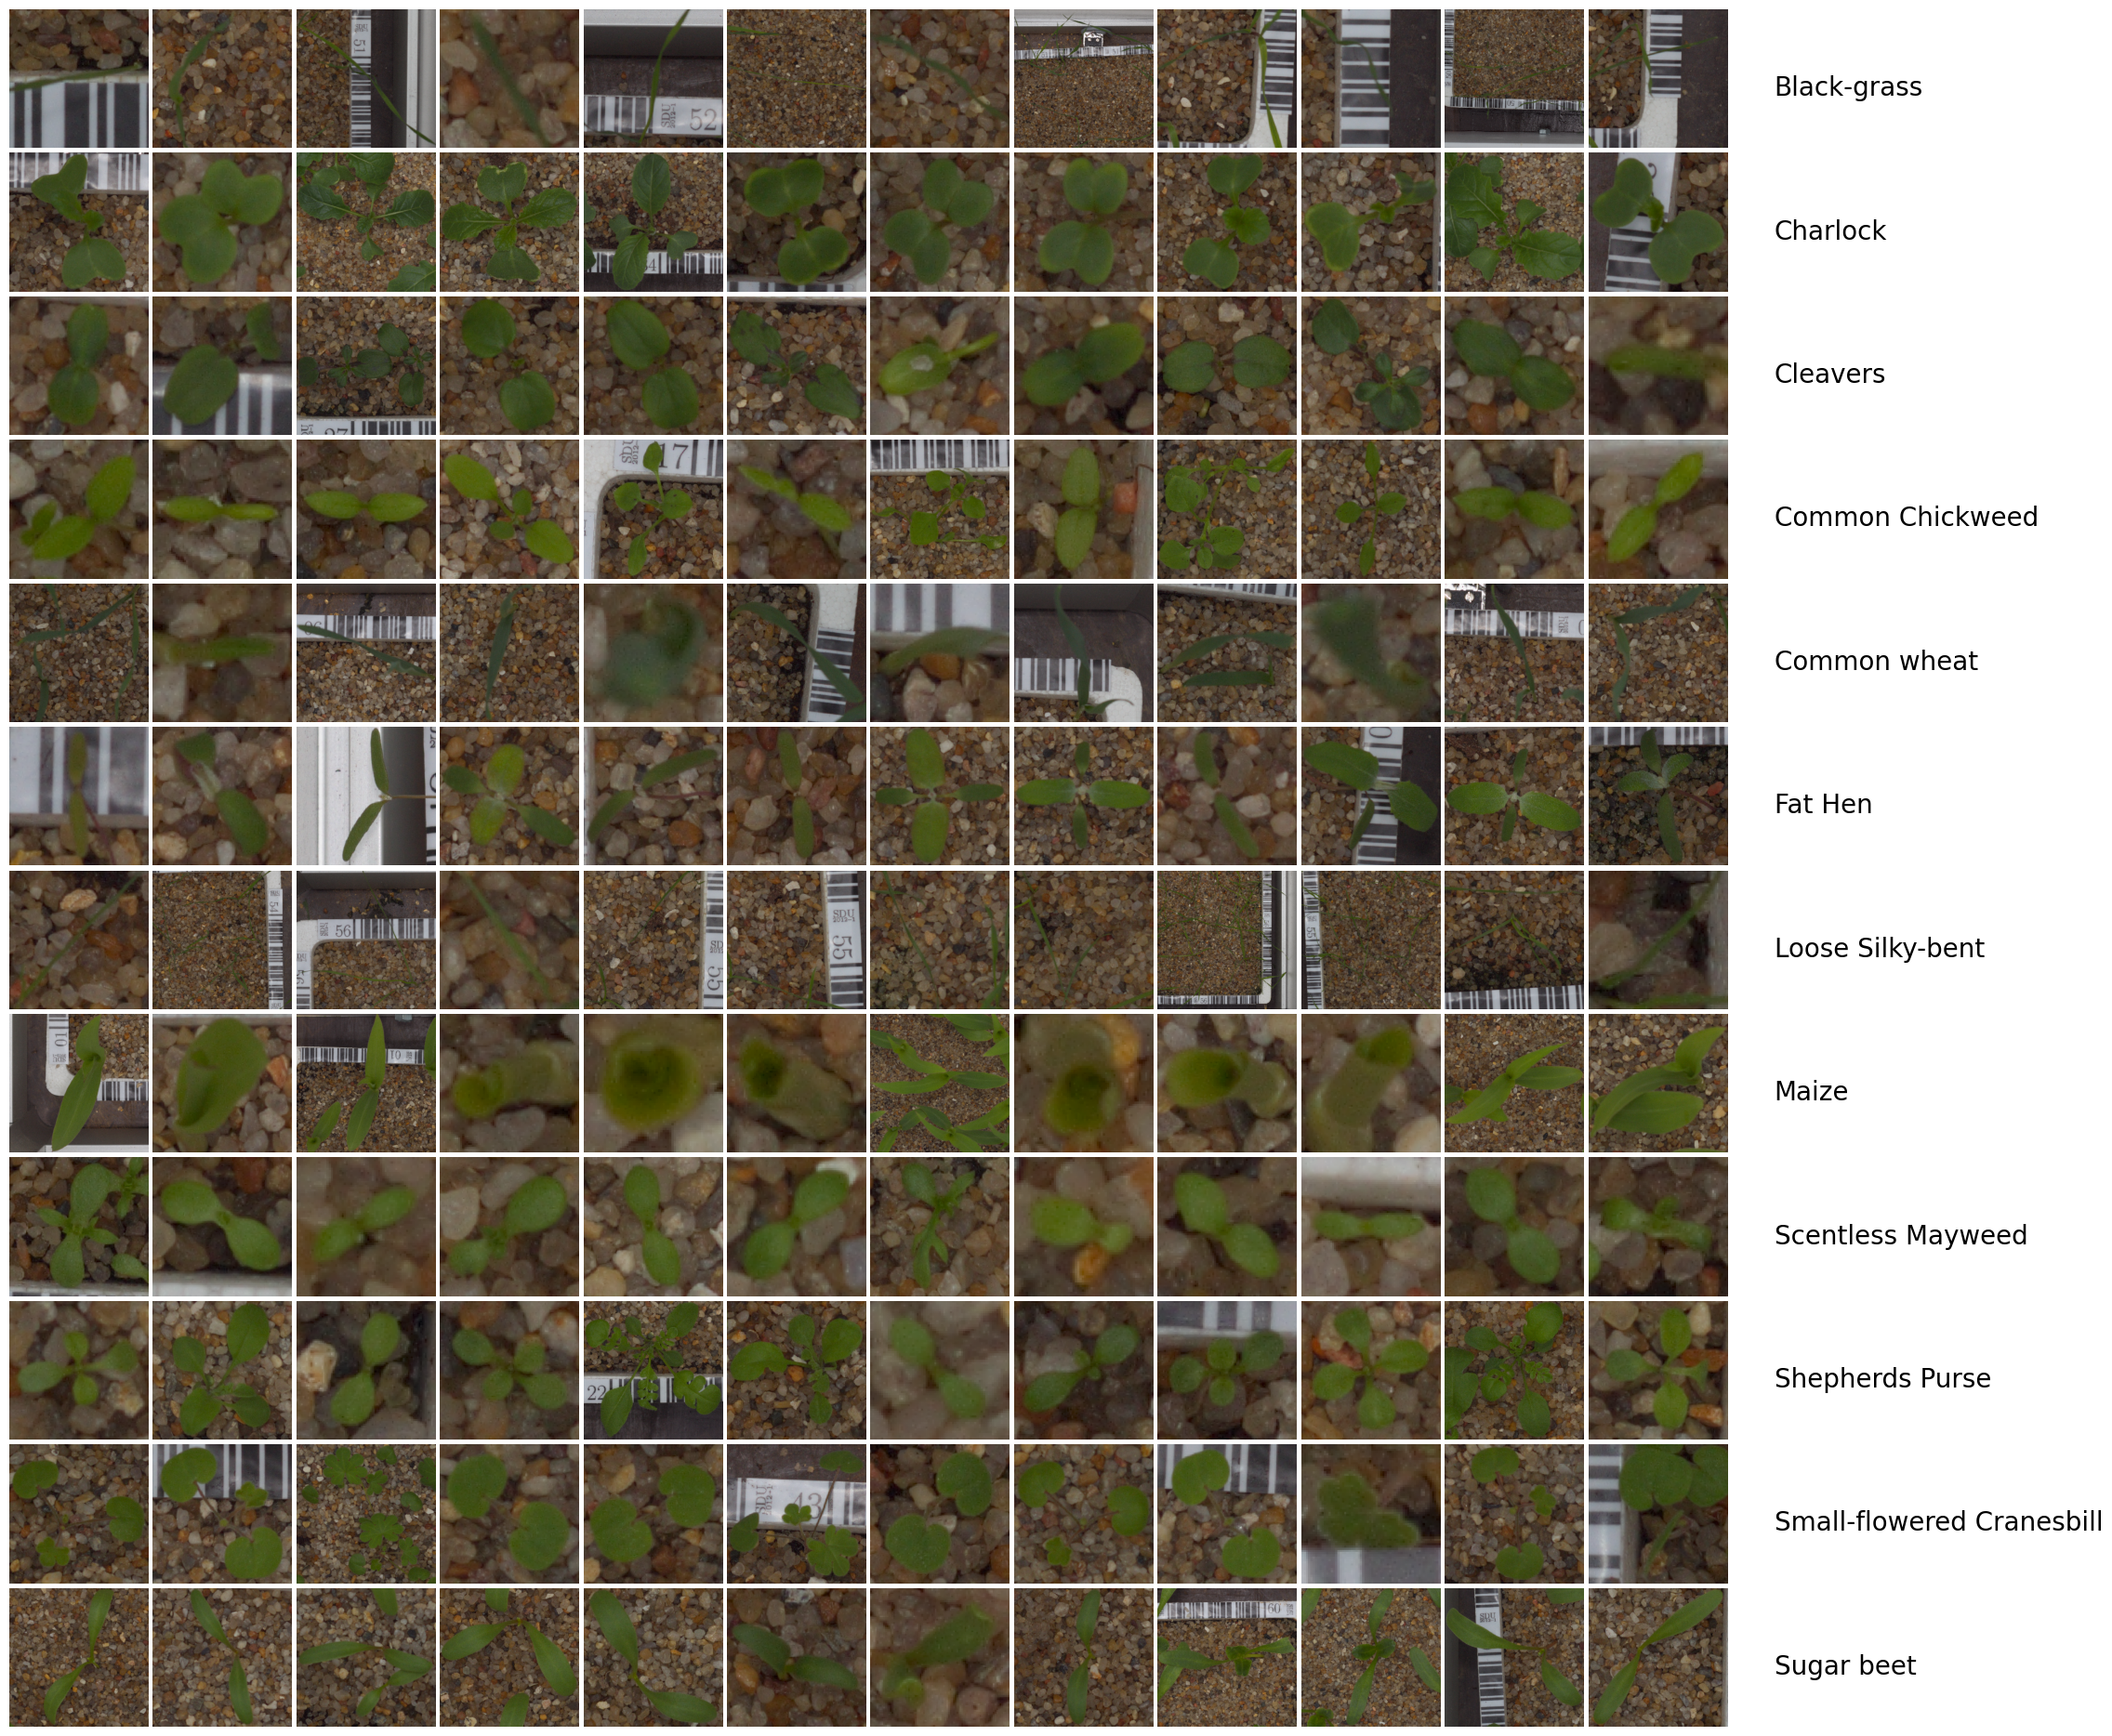

In [49]:
# Set the size for the figure based on the number of categories
fig = plt.figure(figsize=(NUM_CATEGORIES * 2, NUM_CATEGORIES * 2))  # Adjusted size for better visibility

# Set up a grid for displaying images
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)

# Initialize counter for grid position
i = 0

# Iterate through each category and its corresponding images
for category_id, category in enumerate(CATEGORIES):
    # Get file paths for the current category and limit to NUM_CATEGORIES
    filepaths = train_df[train_df['category'] == category]['file'].values[:NUM_CATEGORIES]
    
    for filepath in filepaths:
        ax = grid[i]  # Get the current axis for plotting
        img = read_img(filepath, (299, 299))  # Use (299, 299) for Xception model compatibility
        ax.imshow(img / 255.0)  # Normalize pixel values to [0, 1]
        ax.axis('off')  # Hide axis ticks and labels
        
        # Labeling the last image in each row with the category name
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(400, 170, category, verticalalignment='center', fontsize=20)
        
        i += 1

# Display the plot
plt.show()

**Train-Validation Split**

In [50]:
# Set the random seed for reproducibility
np.random.seed(seed=SEED)

# Generate a random array of floats between 0.0 and 1.0
rnd = np.random.random(len(train_sampled))  # Use train_sampled instead of train for consistency

# Create boolean indices for splitting the dataset
train_idx = rnd < 0.8  # Indices for training set (80% of the data)
valid_idx = rnd >= 0.8  # Indices for validation set (20% of the data)

# Extract category IDs for training and validation sets
y_train = train_sampled.loc[train_idx, 'category_id'].values  # Use consistent naming
y_valid = train_sampled.loc[valid_idx, 'category_id'].values

# Print lengths of training and validation sets
print(f"Number of training samples: {len(y_train)}")
print(f"Number of validation samples: {len(y_valid)}")

Number of training samples: 2132
Number of validation samples: 520


**Preparing image data for training with the Xception model, ensuring that all images are correctly formatted and pre-processed**

In [51]:
# Specify parameters
INPUT_SIZE = 299  # Input size for the Xception model
POOLING = 'avg'   # Pooling method (not used in this snippet but can be relevant later)

# Initialize a numpy array to hold the training images
x_train = np.zeros((len(train_sampled), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')  # Use train_sampled for consistency

# Fill the numpy array with image files converted into their image-3D arrays
for i, file in tqdm(enumerate(train_sampled['file']), total=len(train_sampled)):  # Use train_sampled and set total for progress bar
    img = read_img(file, (INPUT_SIZE, INPUT_SIZE))  # Read the filepath into an array via our function call
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))  # Pre-process that into a format for Xception model
    x_train[i] = x  # Set the i-th example in our initialized zero-4D-array to the particular example

# Print the shape and size of the training images
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))


100%|█████████████████████████████████████████████████████████████████████████████| 2652/2652 [00:25<00:00, 105.72it/s]

Train Images shape: (2652, 299, 299, 3) size: 711,274,356


In [52]:
# Split x_train into training and validation sets based on previously defined indices
X_train = x_train[train_idx]  # Training set
X_valid = x_train[valid_idx]  # Validation set

# Print shapes to confirm dimensions are correct
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_valid.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_valid.shape}")

Training set shape: (2132, 299, 299, 3)
Validation set shape: (520, 299, 299, 3)
Training labels shape: (2132,)
Validation labels shape: (520,)


**Extracting Feature Using Xception Model**

In [53]:
# Forward propagation through pre-trained Xception model for feature extraction
# Note: No classification yet in this step

# Define the Xception model object with pre-trained weights and without the top classification layer
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=POOLING)

# Forward propagation through Xception for feature extraction on training and validation sets
train_x_bf = xception_bottleneck.predict(X_train, batch_size=32, verbose=1)  # Use consistent naming
valid_x_bf = xception_bottleneck.predict(X_valid, batch_size=32, verbose=1)

# Check output dimensions
print("Xception train bottleneck features shape: {} size: {:,}".format(train_x_bf.shape, train_x_bf.size))
print("Xception valid bottleneck features shape: {} size: {:,}".format(valid_x_bf.shape, valid_x_bf.size))

67/67 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step
Xception train bottleneck features shape: (2132, 2048) size: 4,366,336
Xception valid bottleneck features shape: (520, 2048) size: 1,064,960


In [54]:
# Define the logistic regression object with specified parameters
logreg = LogisticRegression(solver='lbfgs', random_state=SEED, max_iter=1000)

# Fit the logistic regression model to the training features and labels
logreg.fit(train_x_bf, y_train)  # Use consistent variable naming

# Predict probabilities for the validation set
valid_probs = logreg.predict_proba(valid_x_bf)  # Get probabilities of each class

# Predict classes for the validation set
valid_preds = logreg.predict(valid_x_bf)  # Get predicted class labels

# Optional: Print a summary of predictions
print("Predicted classes:", valid_preds[:10])  # Display the first 10 predictions
print("Predicted probabilities (first sample):", valid_probs[0])  # Show probabilities for the first sample

Predicted classes: [ 0  3  4 11  9  2  8  4  3  7]
Predicted probabilities (first sample): [4.62117258e-01 2.63942256e-05 6.36312617e-03 5.57808638e-04
 3.67624326e-02 4.24264922e-01 3.67736449e-02 2.19825897e-03
 3.95002084e-03 2.32441809e-02 4.13009655e-05 3.70065221e-03]


In [55]:
# Calculate and print the accuracy score for the validation predictions
validation_accuracy = accuracy_score(y_valid, valid_preds)  # Use consistent variable naming
print(f"Validation Xception Accuracy: {validation_accuracy:.4f}")  # Format the output to 4 decimal places

Validation Xception Accuracy: 0.8538


In [56]:
# Calculate the confusion matrix for validation predictions
cnf_matrix = confusion_matrix(y_valid, valid_preds)  # Use consistent variable naming

# Define class abbreviations for better readability
abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']

# Create a DataFrame to display class names and their abbreviations
class_df = pd.DataFrame({'class': CATEGORIES, 'abbreviation': abbreviation})

# Optional: Print the confusion matrix and the DataFrame for inspection
print("Confusion Matrix:\n", cnf_matrix)
print("\nClass Abbreviations:\n", class_df)

Confusion Matrix:
 [[27  0  0  0  1  0  6  0  0  0  0  0]
 [ 1 42  1  0  0  0  0  0  0  1  2  0]
 [ 0  0 40  1  0  1  0  1  0  1  0  0]
 [ 0  0  0 41  0  2  0  0  5  1  1  0]
 [ 2  0  0  0 30  0  0  2  0  0  0  0]
 [ 0  0  1  2  1 31  0  0  2  0  0  1]
 [14  0  0  0  0  0 30  0  1  0  0  0]
 [ 0  1  0  0  1  0  0 46  0  0  0  1]
 [ 1  0  0  3  0  0  1  1 42  2  0  0]
 [ 1  0  0  0  0  0  0  0  5 40  1  0]
 [ 0  2  1  0  0  0  0  0  0  1 37  0]
 [ 0  0  0  0  2  1  0  0  0  0  0 38]]

Class Abbreviations:
                         class abbreviation
0                 Black-grass           BG
1                    Charlock           Ch
2                    Cleavers           Cl
3            Common Chickweed           CC
4                Common wheat           CW
5                     Fat Hen           FH
6            Loose Silky-bent          LSB
7                       Maize            M
8           Scentless Mayweed           SM
9             Shepherds Purse           SP
10  Small-flower

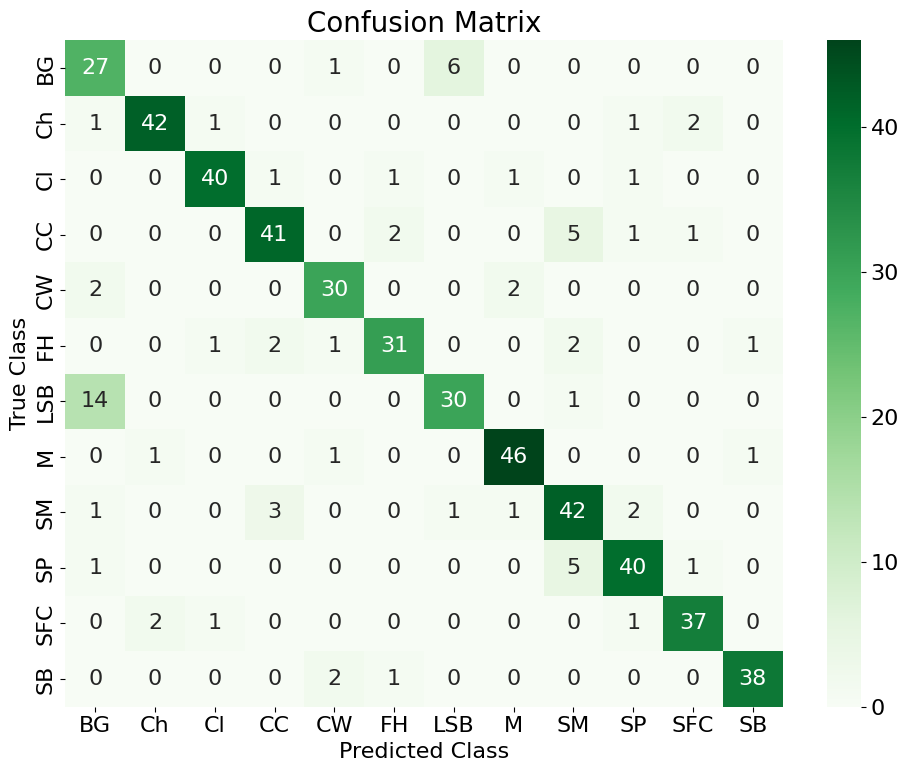

In [57]:
# Calculate the confusion matrix for validation predictions
cnf_matrix = confusion_matrix(y_valid, valid_preds)

# Define class abbreviations for better readability
abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 8))  # Set figure size for better visibility

# Create a heatmap for the confusion matrix using Seaborn
sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True, fmt='d',
            xticklabels=abbreviation, yticklabels=abbreviation)

# Add labels and title
ax.set_title('Confusion Matrix', fontsize=20)
ax.set_ylabel('True Class', fontsize=16)
ax.set_xlabel('Predicted Class', fontsize=16)

# Save the figure as a PNG file with high resolution
fig.savefig('Confusion_matrix.png', dpi=300)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()

In [58]:
# Creating the X input objects for the test data
# Initialize a numpy array to hold the test images
x_test = np.zeros((len(test_df), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')  # Shape: (m_total, height, width, channels)

# Fill the numpy array with image files converted into their image-3D arrays
for i, filepath in tqdm(enumerate(test_df['filepath']), total=len(test_df)):  # Use total for progress bar
    img = read_img(filepath, (INPUT_SIZE, INPUT_SIZE))  # Read the image from the file path
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))  # Pre-process into format for Xception model
    x_test[i] = x  # Store the processed image in the x_test array

# Print the shape and size of the test images dataset
print("Test images dataset shape: {} size: {:,}".format(x_test.shape, x_test.size))

100%|███████████████████████████████████████████████████████████████████████████████| 794/794 [00:03<00:00, 262.67it/s]

Test images dataset shape: (794, 299, 299, 3) size: 212,953,182


In [59]:
# Run forward propagation on the test set input through Xception to get encoded feature representation
test_x_bf = xception_bottleneck.predict(x_test, batch_size=32, verbose=1)  # Forward pass through Xception
print('Xception test bottleneck features shape: {} size: {:,}'.format(test_x_bf.shape, test_x_bf.size))

# Run encoded feature representations through the Logistic Regression classifier
test_preds = logreg.predict(test_x_bf)  # Predict classes for the test set

# Print the first few predictions to inspect
print("Test Predictions (first 10):", test_preds[:10])

25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step
Xception test bottleneck features shape: (794, 2048) size: 1,626,112
Test Predictions (first 10): [10  5 11  3 11  0  3  5  6  6]


In [60]:
# Note: test_preds have shape of (794,) that corresponds to the class for each of the test examples

# Creating the submission file
test_df['category_id'] = test_preds.flatten()  # Ensure the predictions are in the correct shape
test_df['species'] = [CATEGORIES[int(c)] for c in test_df['category_id']]  # Map category IDs to species names

# Select relevant columns and save to CSV
submission_df = test_df[['file', 'species']]
submission_df.to_csv('submission.csv', index=False)  # Save without row indices

print("Submission file created successfully with shape:", submission_df.shape)

Submission file created successfully with shape: (794, 2)


In [61]:
# Generate a classification report
report = classification_report(y_valid, valid_preds, target_names=CATEGORIES)
print(report)

                           precision    recall  f1-score   support

              Black-grass       0.59      0.79      0.68        34
                 Charlock       0.93      0.89      0.91        47
                 Cleavers       0.93      0.91      0.92        44
         Common Chickweed       0.87      0.82      0.85        50
             Common wheat       0.86      0.88      0.87        34
                  Fat Hen       0.89      0.82      0.85        38
         Loose Silky-bent       0.81      0.67      0.73        45
                    Maize       0.92      0.94      0.93        49
        Scentless Mayweed       0.76      0.84      0.80        50
          Shepherds Purse       0.87      0.85      0.86        47
Small-flowered Cranesbill       0.90      0.90      0.90        41
               Sugar beet       0.95      0.93      0.94        41

                 accuracy                           0.85       520
                macro avg       0.86      0.85      0.85    

In [62]:
# Predict probabilities for all classes
valid_probs = logreg.predict_proba(valid_x_bf)

# Calculate ROC-AUC score (one-vs-rest strategy)
roc_auc = roc_auc_score(y_valid, valid_probs, multi_class='ovr')
print(f"ROC AUC Score: {roc_auc:.4f}")

ROC AUC Score: 0.9900


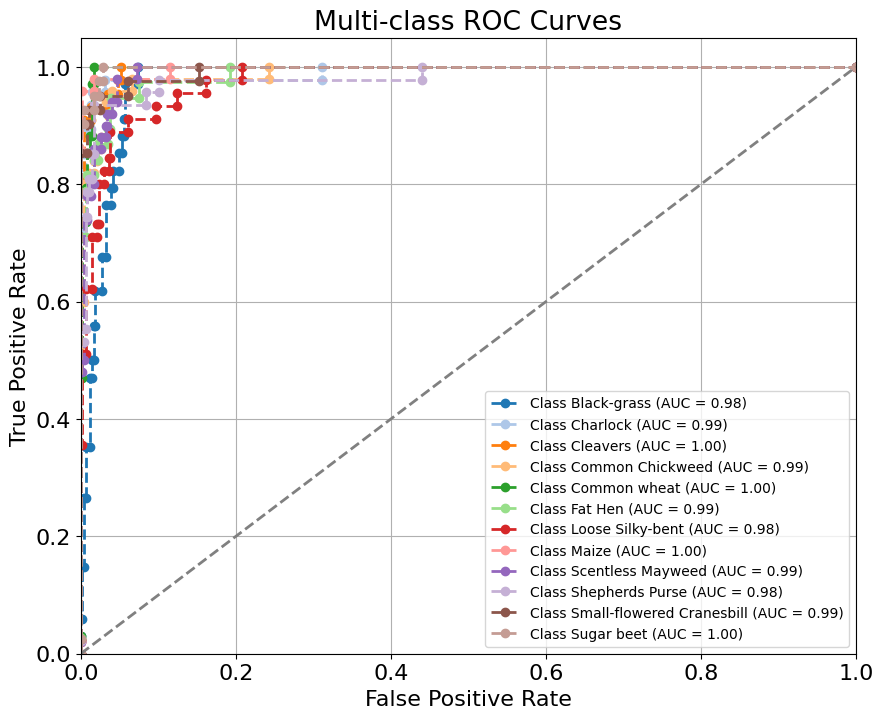

In [63]:
fpr = {}
tpr = {}
roc_auc = {}

# Binarize the labels for multi-class ROC
y_valid_bin = label_binarize(y_valid, classes=range(NUM_CATEGORIES))

# Calculate ROC curve and ROC area for each class
for i in range(NUM_CATEGORIES):
    fpr[i], tpr[i], _ = roc_curve(y_valid_bin[:, i], valid_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot settings
plt.figure(figsize=(10, 8))
colors = cycle(plt.get_cmap('tab20').colors)  # Use 'tab20' colormap for better distinction

for i, color in zip(range(NUM_CATEGORIES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, linestyle='--', marker='o',
             label=f'Class {CATEGORIES[i]} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line for random guessing
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

# Labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curves')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.show()

In [64]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(logreg, train_x_bf, y_train, cv=5)

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f}")

Cross-Validation Scores: [0.84543326 0.85948478 0.83568075 0.85680751 0.83098592]
Mean CV Accuracy: 0.8457
